# Modelos e Estratégias de Trading
## Comportamento do Retorno dos Ativos

Uirá Caiado. 07 de Agosto, 2016

## 1. Estatísticas de Retornos Financeiros

Nesta primeira parte o objetivo é estudar as características estatísticas das distribuições de retornos logarítmicos de cinco diferentes índices de ações. Como não consegui obter estes dados para o *FTSE All Share*, vou seguir apenas com os outros 4 índices. Para começar, vou baixar os dados do *Yahoo! Finance* e orgnizá-los em uma tabela:

In [123]:
# importa bibliotecas necessarias
from pandas_datareader import data, wb
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [124]:
# recupera dados do yahoo
# NOTE: nem o yahoo e nem o google finance voltam dados do FTAS
d_data = {}
l_names = ["S&P 500", "DAX", "Nikkey 225", "Ibovespa"]
l_codes = ['^GSPC','^GDAXI', '^N225', '^BVSP']
ts_start = datetime.datetime(1980, 1, 1)
ts_end = datetime.datetime(2016, 8, 8)
for s_key, s_name in zip(l_codes, l_names):  #, '^FTAS']:
    df = data.get_data_yahoo(s_key, ts_start, ts_end)
    # guarda apenas preco ajustado em dicionario
    d_data[s_key[1:]] = df['Adj Close']
    print u"a primeira data do {} é {:%d/%m/%Y}".format(s_name, df.index[0])

a primeira data do S&P 500 é 02/01/1980
a primeira data do DAX é 26/11/1990
a primeira data do Nikkey 225 é 04/01/1984
a primeira data do Ibovespa é 27/04/1993


In [125]:
# coloca todas as bases para comecar na mesma data
df_prices = pd.DataFrame(d_data)
df_prices.dropna(inplace=True)
df_prices.head()

,BVSP,GDAXI,GSPC,N225
Date,,,,
1993-04-27,24.500000,1640.800049,438.010010,20207.0
1993-04-28,24.299999,1628.900024,438.019989,20455.0
1993-04-30,24.100000,1627.199951,440.190002,20919.0
1993-05-06,25.600000,1623.300049,443.260010,20622.0
1993-05-07,25.799999,1611.900024,442.309998,20811.0


Apesar de ter alguns dados desde 1980, os dados do Ibovespa que tenho acesso começam em 1993. Então, para efeito de comparação, excluí todas os dados dos outros Índices anteriores a este ano. Abaixo vou calcular a mediana, a média, o desvio padrão, o ponto mínimo, o ponto máximo, a assimetria, curtose, o desvio médio absoluto (MAD) e a distância interquartil (IQR) de cada uma das bases a amostra com frequência diária, semanal, mensal e anual:

In [126]:
import scipy.stats.stats as st

def calc_stats(df):
    '''
    Return a dictionary with the median, mean, std deviation,
    minimum value, maximum value, skewness, kurtosis, MAD
    and IQR
    :param df: dataframe. time series of log-returns of
        different assets
    '''
    d_rtn = {}
    # Panda's std() method uses degrees of freedom of 1 by default
    # calcula estatisticas basicas
    d_rtn['Count'] = df.count().to_dict()
    d_rtn['Median'] = df.median().to_dict()
    d_rtn['Mean'] = df.mean().to_dict()
    d_rtn['StdDev'] = df.std(ddof=0).to_dict()
    # recupera min e max
    d_rtn['Min'] = df.min().to_dict()
    d_rtn['Max'] = df.max().to_dict()
    # calcula assimetria
    d_rtn['Skew'] = dict(zip(df_aux.columns, st.skew(df_aux)))
    # calcula curtose
    d_rtn['Kutosis'] = dict(zip(df_aux.columns, st.kurtosis(df_aux)))
    # calcula MAD e IQR
    d_rtn['MAD'] = df.mad()    
    d_rtn['IQR'] = df.quantile(0.75) - df.quantile(0.25)
    # reorganiza dados
    df_rtn = pd.DataFrame(d_rtn).T
    l_idx = ['Count', 'Median', 'Mean', 'StdDev', 'Min', 'Max',
             'Skew', 'Kutosis', 'MAD', 'IQR']
    return df_rtn.ix[l_idx, :]
    

In [127]:
# calcula estatisticas 
l_name = ['1. daily', '2. weekly', '3. monthly', '4. yearly']
d_logrtn = {}
d_logrtn_all = {}
df_rtn = None
for s_frq, s_name in zip(['1D', 'W-FRI', '1M', 'A'], l_name):
    # modifica frequencia dos dados e calcula log retornos
    df_aux = df_prices.resample(s_frq).last()
    df_aux = np.log(df_aux/df_aux.shift()).dropna()
    # calcula estatisticas e guarda resultados na mesma estrutura
    df_test = calc_stats(df_aux)
    df_iqr = df_test.ix['IQR', :]
    l_idx = df_test.index
    df_test.index = [[s_name] * len(l_idx), df_test.index]    
    if s_frq == '1D':
        df_rtn = df_test.copy()
    else:
        df_rtn = pd.concat([df_rtn, df_test])
    #guarda dados sem outliers (1.5 * IQR)
    l_no_out_liers = ((df_aux <= df_aux.quantile(0.75) + 1.5 * df_iqr) & 
                      (df_aux >= df_aux.quantile(0.25) - 1.5 * df_iqr)).sum(axis=1)==4
    d_logrtn_all[s_name] = df_aux
    d_logrtn[s_name] = df_aux[l_no_out_liers]

In [9]:
# imprime resultados das estatisticas por periodo
df_rtn

BVSP        GDAXI         GSPC         N225
1. daily   Count    3894.000000  3894.000000  3894.000000  3894.000000
           Median      0.001390     0.000794     0.000672     0.000199
           Mean        0.001505     0.000128     0.000303    -0.000123
           StdDev      0.022425     0.014367     0.011387     0.014545
           Min        -0.172082    -0.072703    -0.094695    -0.121110
           Max         0.228116     0.106851     0.102457     0.094941
           Skew        0.145602    -0.210270    -0.188665    -0.573797
           Kutosis     7.053013     3.358985     6.786787     5.886725
           MAD         0.015733     0.010294     0.007820     0.010490
           IQR         0.023104     0.014675     0.010690     0.015791
2. weekly  Count    1215.000000  1215.000000  1215.000000  1215.000000
           Median      0.006228     0.004855     0.002732     0.001457
           Mean        0.006403     0.001529     0.001317    -0.000188
           StdDev      0.051719     0.031515     0.023419     0.030472
           Min        -0.293351    -0.243470    -0.200838    -0.278844
           Max         0.351918     0.149422     0.113559     0.114497
           Skew        0.264375    -0.843994    -0.859391    -0.786575
           Kutosis     5.118940     5.955361     7.001412     6.290145
           MAD         0.036086     0.022992     0.016543     0.022953
           IQR         0.051884     0.035218     0.024039     0.036751
3. monthly Count     280.000000   280.000000   280.000000   280.000000
           Median      0.018170     0.013817     0.011129     0.003091
           Mean        0.027785     0.006636     0.005715    -0.000815
           StdDev      0.119277     0.062481     0.042367     0.058690
           Min        -0.503413    -0.293327    -0.185636    -0.272162
           Max         0.679202     0.193738     0.102307     0.149670
           Skew        0.947240    -0.860704    -0.858302    -0.554707
           Kutosis     5.480877     2.569345     1.789944     1.097969
           MAD         0.081331     0.046407     0.031836     0.045697
           IQR         0.110263     0.072379     0.051284     0.073784
4. yearly  Count      23.000000    23.000000    23.000000    23.000000
           Median      0.071361     0.148937     0.104701     0.006057
           Mean        0.218853     0.066373     0.066854    -0.001957
           StdDev      0.587839     0.244735     0.184797     0.231809
           Min        -0.531427    -0.578790    -0.506836    -0.546864
           Max         2.450569     0.380047     0.286424     0.449290
           Skew        2.273065    -1.224154    -1.374617    -0.165764
           Kutosis     6.368205     0.914083     1.966505    -0.251998
           MAD         0.392026     0.189889     0.137394     0.187660
           IQR         0.496135     0.291104     0.220844     0.315518

Olhando os números dispostos desta maneira, não fica tão fácil a comparação. Para ajudar na análise, vou criar um *heatmap* de cada uma das estatísticas calculadas acima.

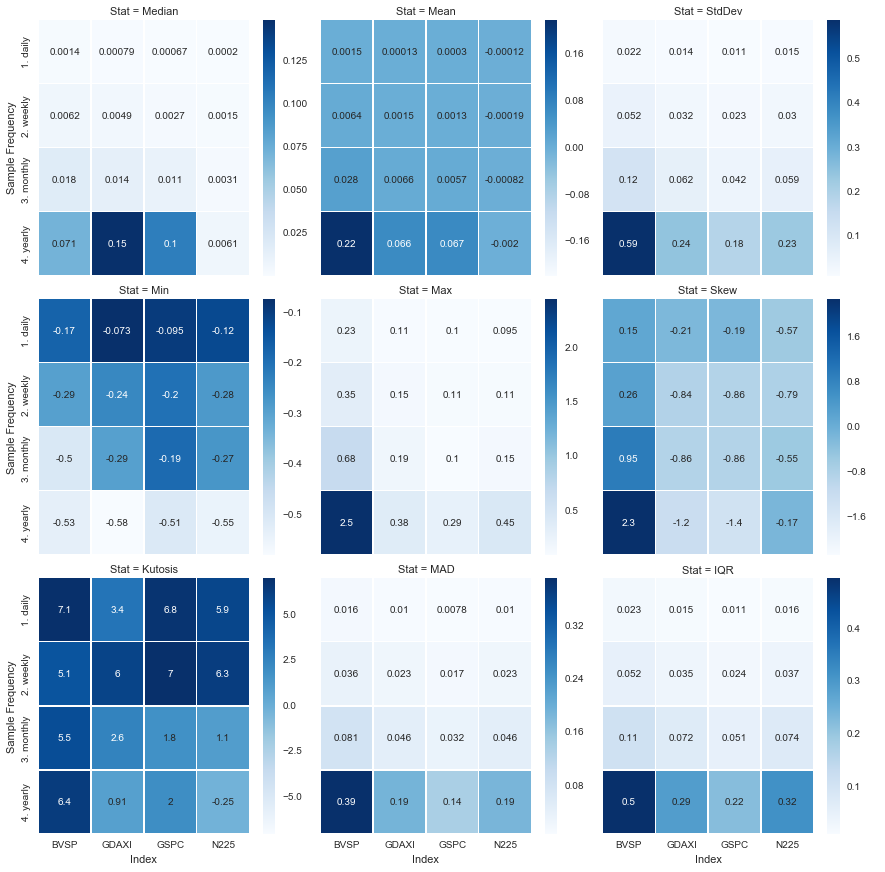

In [16]:
# arruma estrutura os dados para usar em plot
df_rtn2 = df_rtn.stack().reset_index()
df_rtn2.columns = ['Sample', 'Stat', 'Index', 'Value']
df_rtn2 = df_rtn2[df_rtn2.Stat != 'Count']

# cria funcao para fazer cada heatmap
def facet(data, color):
    data = data.pivot(index="Sample", columns='Index', values='Value')
    g = sns.heatmap(data, annot=True, linewidths=.5, cmap='Blues')

#plota o heatmap de cada estatistica
with sns.plotting_context(font_scale=5.5):
    g = sns.FacetGrid(df_rtn2, col="Stat", col_wrap=3, size=4, aspect=1)
    g = g.map_dataframe(facet)
    g.add_legend()
    g.set_xlabels('Index')
    g.set_ylabels('Sample Frequency')

Esperava observar um aumento nos valores de cada estatística quando diminuímos a frequência dos dados (diário para semanal, por exemplo), porém isso não aconteceu para a curtóse e para a assimetria. Também olhando para os dados desta maneira é possível perceber algums fatos curiosos:
- A mediana anual mais alta foi fo índice DAX
- Todas as médias do *Nikkey 225* são negativas, independente da frequência (e sua volatilidade anual não é baixa)
- O pior retorno anual de todos os Indices foi semelhante
- A assimetria de nenhuma distribuição ficou perto de 0 (zero)
- O desvio médio absoluto, no geral, é inferior ao desvio padrão

Agora, vou checar visualmente a distribuição dos retornos e sobrepor como seria a distribuição normal deles se considerasse o mesmo desvio e média. Note que os eixos X e Y tem amplitudes diferentes em cada gráfico.

In [129]:
# reorganiza dados para plotagem de heatmap
df_plot = None
for s_name in l_name:
    df_aux = d_logrtn[s_name].copy()
    df_aux.index = [[s_name] * len(df_aux.index), df_aux.index]
    if s_frq == '1D':
        df_plot = df_aux.copy()
    else:
        df_plot = pd.concat([df_plot, df_aux])

df_plot = df_plot.stack().reset_index()
df_plot.columns = ['Freq', 'Date', 'Index', 'Return']

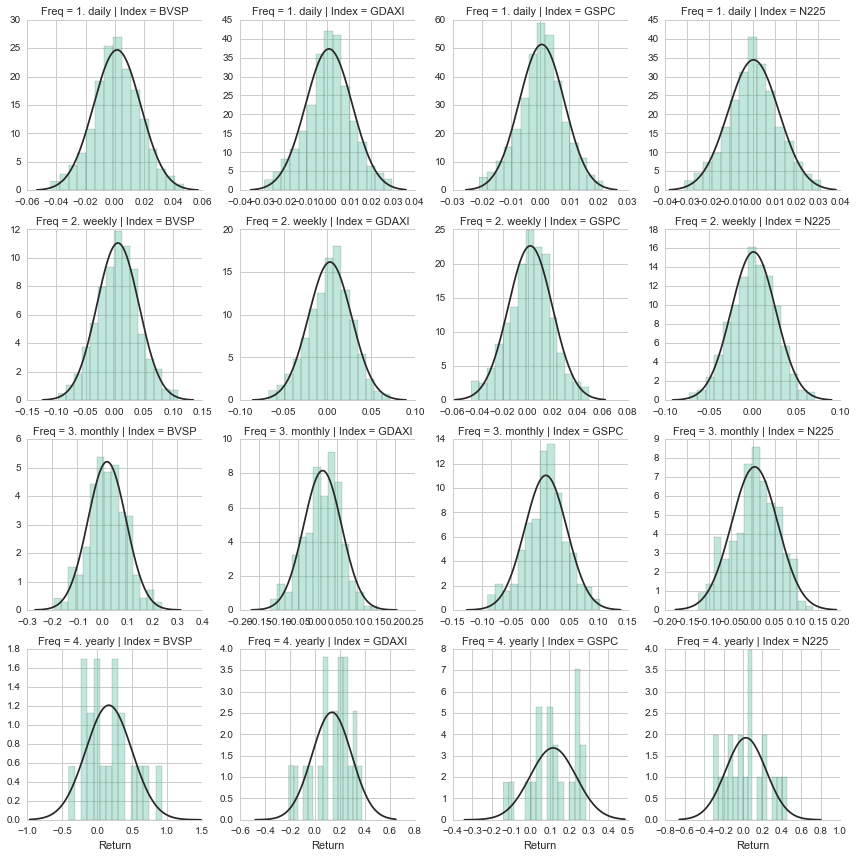

In [130]:
# pltando dados sem out-liers
g = sns.FacetGrid(df_plot, col="Index",
                  row='Freq', sharex=False,
                  sharey=False)
g.map(sns.distplot, "Return", bins=15, kde=False,
      fit=stats.norm);

Para alguns dos gráficos acima, não ficou tão claro se realmente não podem ser considerados normalmente distribuídos. Abaixo, vou aplicar o teste [Jarque-Bera](https://en.wikipedia.org/wiki/Jarque–Bera_test) para testar a normalidade das distribuições e imprimir o p-valor dos teste para cada Índice/Frequência:

In [19]:
# imprime p-values dos testes
df_jarque_bera = df_plot.groupby(['Freq', 'Index']).aggregate(stats.jarque_bera)
pd.DataFrame([[x[0][1]] for x in df_jarque_bera.values], index=df_jarque_bera.index,
             columns=['p-value'])

p-value
Freq       Index          
1. daily   BVSP   0.827902
           GDAXI  0.041758
           GSPC   0.029428
           N225   0.559243
2. weekly  BVSP   0.998951
           GDAXI  0.011183
           GSPC   0.174028
           N225   0.117950
3. monthly BVSP   0.983525
           GDAXI  0.194519
           GSPC   0.143611
           N225   0.153363
4. yearly  BVSP   0.630335
           GDAXI  0.453847
           GSPC   0.620602
           N225   0.714038

A hipótese nula é que a distribuição é normal. O teste consiste em testar se a assimetria e o excesso de curtose (curtose - 3) são zero, como é esperado por uma distribuição normal. Curiosamente, o teste não rejeitou a hipótese nula de que o *S&P 500* e o *DAX* na frequência diária sejam normais e que o *DAX* seja normal na frequência semanal (todos com 5% de confiança).


## 2 Replicação do Índice Bovespa

Nesta segunda parte o objetivo é praticar a agregação transversal de retornos financeiros através da replicação de um índice de ações. Neste caso o objetivo é a replicação do Índice Bovespa (IBOV) através dos retornos individuais das ações compõem o índice através da fórmula:
$$IBOV_t = IBOV_{t-1} \, \times \, \left(  1 + \sum_{i=1}^{N} \omega_{i, \, t} \times R_{i, \, t} \right)$$

Onde $R_{i, \, t}$ é o retorno da ação $i$ na data $t$ e $\omega_{i, \, t}$ é o peso da ação $i$ na carteira do índice na data $t$. Vamos começar baixando os dados de cada ativo. Vou baixar os pelo Yahoo! Finance e, quando não disponíveis, baixarei pelo Google Finance. Porém, isso implicará em erro nos cálculos, uma vez o Google Finance não fornece o fechamento corrigido pels eventos, como o yahoo.

In [10]:
import pandas as pd
l_assets = list(pd.read_excel('DadosReplicacao.xlsx', sheetname='LISTA').T.values[0])
df_redutor = pd.read_excel('DadosReplicacao.xlsx', sheetname='Redutor',
                           skiprows=1, index_col='Data')
df_qtd = pd.read_excel('DadosReplicacao.xlsx', sheetname='Qtd.Teorica', index_col='Data')

In [28]:
# recupera dados do yahoo
# NOTE: nem o yahoo e nem o google finance voltam dados do FTAS
d_assets = {}
ts_start = datetime.datetime(2015, 1, 5)
ts_end = datetime.datetime(2015, 8, 3)
for s_key, s_name in zip(l_assets, l_assets):  #, '^FTAS']:
    try:
        df = data.get_data_yahoo(s_key + '.SA', ts_start, ts_end)
        df = df['Adj Close']
    except:
        print "{} foi recuperado do Google Finance".format(s_key)
        df = data.get_data_google('BVMF:' + s_key, ts_start, ts_end)
        df = df['Close']
    # guarda apenas preco ajustado em dicionario
    d_assets[s_key] = df
#     print u"a primeira data do {} é {:%d/%m/%Y}".format(s_name, df.index[0])
print "Feito!"

ALLL3 foi recuperado do Google Finance
KLBN11 foi recuperado do Google Finance
SANB11 foi recuperado do Google Finance
TBLE3 foi recuperado do Google Finance
Feito!


Agora, preciso calcular o peso das ações no retorno do índice cada dia. Primeiro, vou replicar o índice usando as quantidades teóricas:

In [118]:
# redimensiona dados
df_assets = pd.DataFrame(d_assets)
df_assets2 = df_assets.ix[df_qtd.index, df_qtd.columns]
# os dados do yahoo em julho estao multiplicados por 10. Efetua correcao
df_assets2.ix[df_assets2.RUMO3>60., 'RUMO3'] /=10.
# calcula ibov
df_ibov = (df_qtd * df_assets2).sum(axis=1) / df_redutor['Redutor']

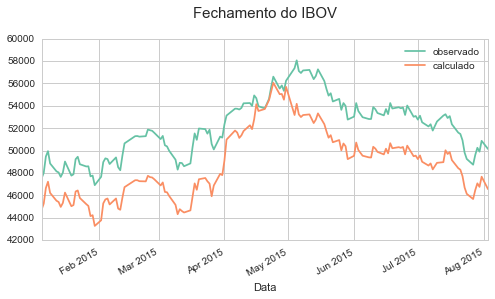

In [119]:
# plota comparacao
ax = df_redutor['Fechamento'].plot(label='observado', legend=True)
df_ibov.plot(ax=ax, label='calculado', legend=True)
ax.set_title("Fechamento do IBOV\n", fontsize=15);

Além do deslocamento no eixo Y provavelmente por estar usando dados com eventos mais recentes descontados, há alguma inconsistência por volta de Abril/2015, aparentemente. Depois parece que foi corrigido. Consegui apenas localizar o erro relacionados às cotações da RUMO3. Como replicar o índice pelo método tradicional não é o objetivo deste trabalho, vou extrair o peso das ações destes dados mesmo.

In [120]:
print u"dimensões da matriz de quantidade: ({}, {})".format(*df_qtd.shape)
print u"dimensões da matriz de preços: ({}, {})".format(*df_assets2.shape)
print u"dimensões da matriz do redutor: ({}, {})".format(df_redutor['Redutor'].shape[0], 1)
print u"dimensões da matriz do IBOV: ({}, {})".format(df_ibov.shape[0], 1)

dimensões da matriz de quantidade: (144, 70)
dimensões da matriz de preços: (144, 70)
dimensões da matriz do redutor: (144, 1)
dimensões da matriz do IBOV: (144, 1)


In [121]:
# amostra dos dados calculados antes de serem acumulados
df_omega = ((df_qtd * df_assets2).T / (df_redutor['Redutor']*df_ibov)).T
df_aux = (1+(df_omega * df_assets2.pct_change()).sum(axis=1))
df_aux.head()

Data
2015-01-05    1.000000
2015-01-06    1.013041
2015-01-07    1.031060
2015-01-08    1.012346
2015-01-09    0.979304
dtype: float64

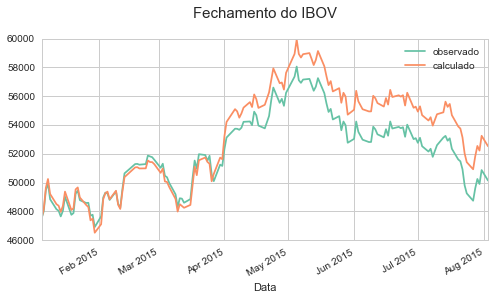

In [122]:
# usa como ponto inicial o fechamnto dado em planilha
df_ibov2 = (df_aux.cumprod() * df_redutor.Fechamento.iloc[0])
# plota comparacao
ax = df_redutor['Fechamento'].plot(label='observado', legend=True)
df_ibov2.plot(ax=ax, label='calculado', legend=True)
ax.set_title("Fechamento do IBOV\n", fontsize=15);

Utilizando como ponto de partida o fechamento dado em planilha e o método de cálculo proposto no início desta seção, fica claro a diferença mencionada anteriormente. No início de Abril/15 aconteceu um rebalanceamento de carteira, que pode ter introduzido este erro nos cálculos.

*Style notebook and change matplotlib defaults*

In [1]:
#loading style sheet
from IPython.core.display import HTML
HTML(open('ipython_style.css').read())

In [117]:
#changing matplotlib defaults
%matplotlib inline
import seaborn as sns
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8, 4)})
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("Set2", 10))